## A single, interactive, synthetic ("twin") experiment
If run as a script in a terminal (i.e. not as a jupyter notebook)
then the liveplotting is *interactive* (can be paused, skipped, etc).

### Imports
<b>NB:</b> On <mark><b>Gooble Colab</b></mark>,
*replace* `%matplotlib notebook` (right below) by\
`!python -m pip install git+https://github.com/nansencenter/DAPPER.git`

In [1]:
%matplotlib notebook

In [2]:
import dapper as dpr
import dapper.da_methods as da

Generate the same random numbers each time this script is run:

In [3]:
dpr.set_seed(3000);

### Load experiment setup: the hidden Markov model (HMM)

In [4]:
from dapper.mods.Lorenz63.sakov2012 import HMM
HMM  # ⇒ printout (in notebooks)

HiddenMarkovModel({
     'Dyn': 
         Operator({
              'M': 3,
              'model':
                  rk4 integration of <function dapper.mods.Lorenz63.dxdt(x)>
                  <function with_rk4.<locals>.step at 0x119028720>,
              'noise':
                  GaussRV({
                           'mu': array([0., 0., 0.]),
                            'M': 3,
                            'C': 0
                          }),
              'linear': <function dstep_dx at 0x119028540>
             }),
     'Obs': 
         <TimeDependentOperator> CONSTANT operator sepcified by .Op1:
         Operator({
              'M': 3,
              'model':
                  Direct obs. at [0 1 2]
                  <function partial_Id_Obs.<locals>.model at 0x119028c20>,
              'noise':
                  GaussRV({
                            'C': <CovMat>
                                       M: 3
                                    kind: 'diag'
                         

### Simulate synthetic truth (xx) and noisy obs (yy)
A variable named `<char><char>` conventionally refers to a *time series* of `<char>`.

In [5]:
HMM.tseq.T = 30  # shorten experiment
xx, yy = HMM.simulate()

Truth & Obs: 100%|█████████████| 3000/3000 [00:00<00:00, 42197.63it/s]


### Specify a DA method
Here "xp" is short for "experiment" configuration.

In [6]:
# xp = da.OptInterp()
# xp = da.Var3D()
# xp = da.ExtKF(infl=90)
xp = da.EnKF("Sqrt", N=10, infl=1.02, rot=True)
# xp = da.PartFilt(N=100, reg=2.4, NER=0.3)
xp  # ⇒ printout (in notebooks)

EnKF(upd_a='Sqrt', N=10, infl=1.02, rot=True, fnoise_treatm='Stoch')

### Assimilate yy
Note that the assimilation "knows" the HMM,
but `xx` is only used for performance *assessment*.

In [7]:
xp.assimilate(HMM, xx, yy)

EnKF: 100%|████████████████████| 3000/3000 [00:00<00:00, 14291.97it/s]


### Average the time series
Computes a set of different statistics.

In [8]:
# print(xp.stats)  # ⇒ long printout
xp.stats.average_in_time()

Print some of these time-averages

In [9]:
# print(xp.avrgs)  # ⇒ long printout
print(xp.avrgs.tabulate(["rmse.a", "rmv.a"]))

rmse.a  1σ    rmv.a  1σ  
------------  -----------
  0.78 ±0.06   0.57 ±0.07


### Replay liveplotters

Initializing liveplots...


<IPython.core.display.Javascript object>


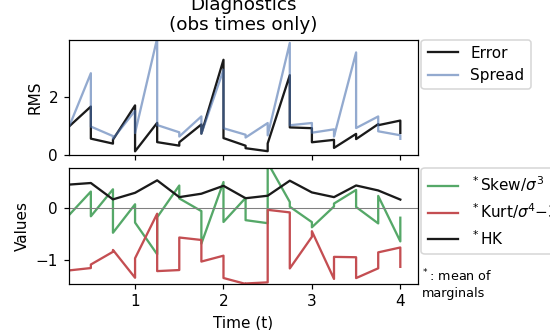

<IPython.core.display.Javascript object>


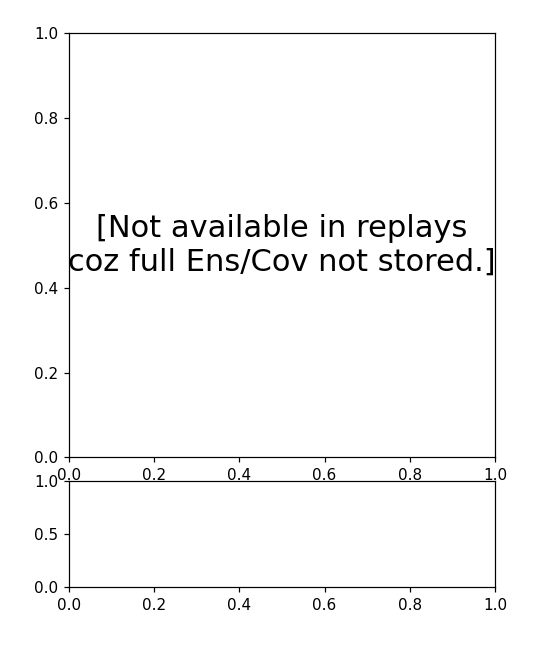

<IPython.core.display.Javascript object>


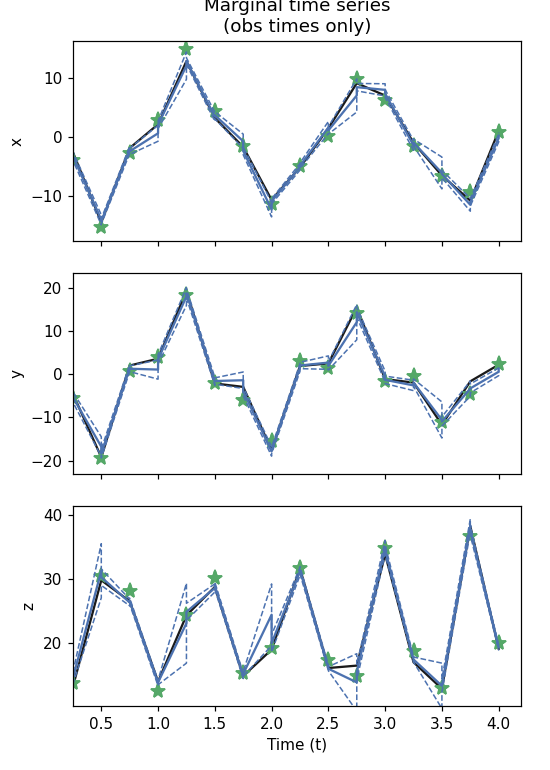

<IPython.core.display.Javascript object>


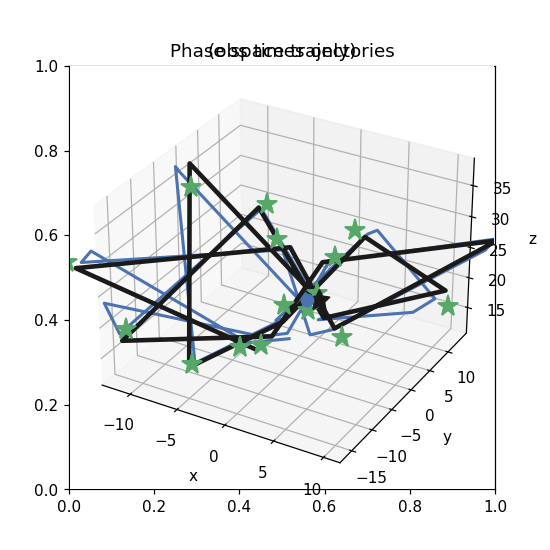

EnKF (replay): 100%|███████████| 3000/3000 [00:00<00:00, 15191.34it/s]


In [10]:
xp.stats.replay(
    # speed=.6  # `speed` does not work in notebooks
)

### Further diagnostic plots

In [11]:
import dapper.tools.viz as viz

<IPython.core.display.Javascript object>


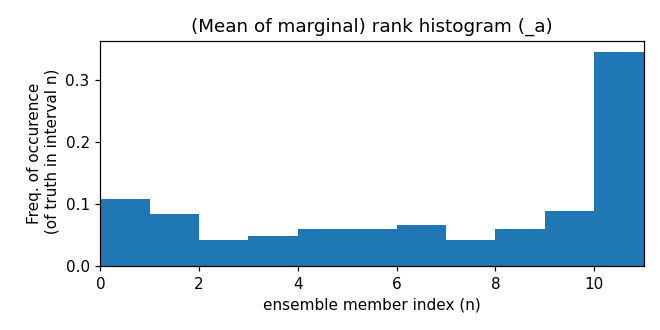

<IPython.core.display.Javascript object>


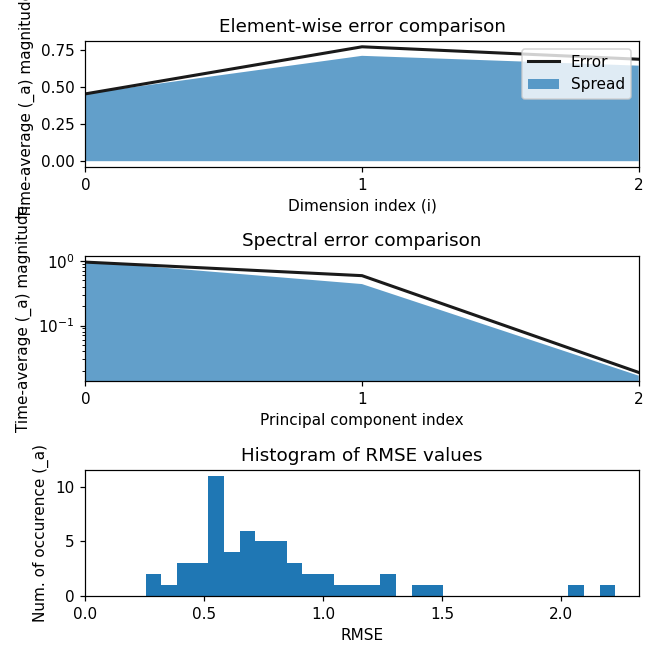

<IPython.core.display.Javascript object>


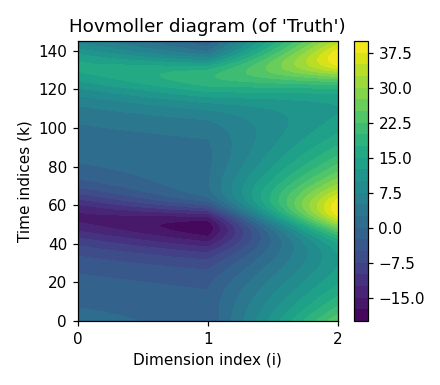

In [12]:
viz.plot_rank_histogram(xp.stats)
viz.plot_err_components(xp.stats)
viz.plot_hovmoller(xx)

### Excercise (methods)
- Try out each of the above DA methods (currently commented out).
- Next, remove the call to `replay`, and set `liveplots=False` above.
- Now, use the iterative EnKS (`iEnKS`), and try to find a parameter combination
  for it so that you achieve a lower `rmse.a` than with the `PartFilt`.

*Hint*: In general, there is no free lunch. Similarly, not all methods work
for all problems; additionally, methods often have parameters that require
tuning. Luckily, in DAPPER, you should be able to find suitably tuned
configuration settings for various DA methods *in the files that define the
HMM*. If you do not find a suggested configuration for a given method, you
will have to tune it yourself. The example script `basic_2` shows how DAPPER
facilitates the tuning process, and `basic_3` takes this further.

### Excercise (models)
Run an experiment for each of these models

- LotkaVolterra
- Lorenz96
- LA
- QG

### Excercise (diagnostics)
- Create a new code cell, and copy-paste the above `print(...tabulate)`
  command into it. Then, replace `rmse` by `err.rms`. This should yield
  the same printout, as is merely an abbreviation of the latter.
- Next, figure out how to print the time average *forecast (i.e. prior)* error
  (and `rmv`) instead. Explain (in broad terms) why the values are larger than
  for the *analysis* values.
- Finally, instead of the `rms` spatial/field averages,
  print the regular mean (`.m`) averages. Explain why `err.m` is nearly zero,
  in contrast to `err.rms`.

### Excercise (memory)
Why are the replay plots not as smooth as the liveplot?

*Hint*: provide the keyword `store_u=True` to `assimilate()` to avoid this.